In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts
import custom_ts_length

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

# Set display options to show all rows and columns
pd.set_option('display.max_rows', 50)  # Show rows
pd.set_option('display.max_columns', 160)  # Show columns

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
%%capture captured_output
#generate all path names and class list(s) etc. 
channels = constants.channel_list
paths , class_list, sleep_night_list , sleep_type_list , participant_id_list = constants.generate_paths_and_info(blue_pebble = True)

In [8]:
%%capture captured_output

t1 = time.time()

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
data_type = ['Wake', 'N1', 'N2','N3', 'REM'][0]
paths = joblib.load(folder + data_type + '_paths.pkl')

#Load each raw dataframe and convert into a row for the larger dataframe 
overall_dfs_rows = []

for path in paths['selected_paths']:
    data_epo = mne.read_epochs(path)
    df_full = data_epo.to_data_frame()

    #Convert the dataframe into a row
    new_row = {}
    for col in df_full.columns: #iterate through feature columns   
        series = df_full[col] #This gives you the series that you want to append to the new dataframe
        new_row[str(col)] = series
    
    overall_dfs_rows.append(new_row)

df_all_samples = pd.DataFrame(overall_dfs_rows)

t2 = time.time()

time_taken = t2 - t1 #takes around 10 seconds for the Wake Data

In [11]:
# df_all_samples.head()

#### Do TSFresh Feature Extraction on the raw signal

In [17]:
t1 = time.time()
#Choose how many minutes of the Raw EEG data you actually want to use
mins = 5


for mins in [1,2,3,4,5]:
    new_length = 256*60*mins #convert minutes to the number of data points
    df_snipped = custom_ts_length.customise_df_ts_length(df_all_samples, new_length, impute = True)
    df_snipped = df_snipped.drop(columns = ['time', 'condition', 'epoch'] )


t2 = time.time()

t2-t1

10.094746112823486

In [20]:
#Convert into TS_Fresh format Dataframe so that TS Fresh statistics can be calculated
ts_fresh_df = format_eeg_data.convert_sktime_df_to_ts_fresh_format(df_snipped, ts_cols = list(df_snipped.columns))

In [47]:
%%capture captured_output


#2. Extract TS_Fresh Features from the dataframe

timings_dict = {}
timings_dict['times'] = []
timings_dict['n_channels'] = []

for i in range(1,57,5):
    
    t1 = time.time()
    
    subset_df = ts_fresh_df.iloc[:, :1 + i].copy()
    subset_df['time'] = ts_fresh_df['time']
    
    settings = MinimalFCParameters()
    # settings = EfficientFCParameters()
    
    extracted_ts_fresh_df = extract_features(subset_df, column_id = 'id' , column_sort = 'time',  default_fc_parameters=settings)

    t2 = time.time()
    time_taken = t2-t1
    
    timings_dict['times'].append(time_taken)
    
    timings_dict['n_channels'].append(i)
    print(str(i) + '  done..!')

14-Dec-23 15:55:51 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:55:55 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:00 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:06 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:14 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:23 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:33 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:45 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:56:58 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
14-Dec-23 15:57:12 | WARNING | Depend

### Time Taken vs Num Channels for 5 minutes of Raw EEG data and 55 samples (linear relationship)

In [53]:
from sklearn.linear_model import LinearRegression

In [63]:
X = np.array( copied_dict['n_channels'] ).reshape(-1,1)
y = np.array( copied_dict['times'] )
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_

array([0.27263844])

In [65]:
reg.intercept_

3.218890228582712

Text(0.5, 0, 'Num Channels')

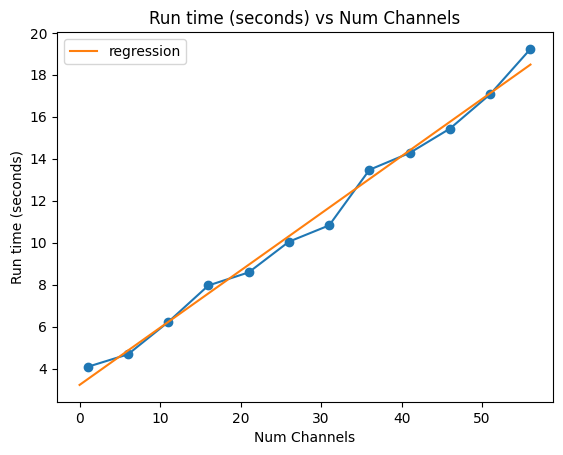

In [69]:
# copied_dict = timings_dict.copy()
plt.title('Run time (seconds) vs Num Channels')

plt.scatter(copied_dict['n_channels'], copied_dict['times'])
plt.plot(copied_dict['n_channels'], copied_dict['times'])
plt.plot([i for i in range(0,57,1)], [ (reg.coef_*i + reg.intercept_) for i in range(0,57,1)], label = 'regression')
plt.legend()

plt.ylabel('Run time (seconds)')
plt.xlabel('Num Channels')